In [372]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
import scipy
import matplotlib.patches as patches
import pandas as pd
from scipy.io import readsav
from regions import Regions #read_ds9, write_ds9
import csv
import math
from scipy.optimize import curve_fit
import time
from pathlib import Path
from pyds9 import ds9
from scipy.integrate import quad
from astropy.table import QTable, Table, Column, vstack
from astropy.visualization.stretch import AsinhStretch
from astropy.visualization import ImageNormalize, simple_norm
import matplotlib.patches as patches
import pymc as pm
import arviz as az
import random

In [2]:
hdr = fits.getheader('ISF_Mosaic_Trial5_drz_sci.fits')
im  = fits.getdata('ISF_Mosaic_Trial5_drz_sci.fits')
wcs = WCS(hdr)

In [3]:
def write_regf(ra, dec, fname, c, text, r=None, update=False):
    """
    fname - file name to be written
    c - region color
    """
    xx, yy = ra, dec
    text = np.array(text, dtype=str)
    if r==None:
        r =25
    else:
        r=r
    if update == True:
        with open(fname) as unt:
            lines = unt.readlines()
        with open(fname, 'w') as unt:    
            unt.writelines(lines)

            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')
    else:
        with open(fname, 'w') as unt:
            unt.write('fk5')
            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')

In [4]:
def norm_logistic_reg(x, mu, sig):
    w = 1/(1+np.exp(-((x-mu)/sig)))
    return w

def r_times_logistic_reg(x, m, s):
    w = x/(1+np.exp(-((x-m)/s)))
    return w

In [56]:
df_params = pd.read_csv('mu_sig_params.csv')
mu, sig = np.array(df_params['mu']), np.array(df_params['sig'])
df_flame = pd.read_csv('dm_sep_flame.csv')
sep_flame, dm_flame = np.array(df_flame['sep']), np.array(df_flame['dm'])

In [6]:
df_final = pd.read_csv('dash_rereduce_removed_combined_with_rereduceII_with_VISION.csv')
df_final2 = df_final
ra_f2 = np.array(df_final2['RA_d'])
dec_f2 = np.array(df_final2['DEC_d'])
m_f2 = np.array(df_final2['MAG_d'])
me_f2 = np.array(df_final2['MAG_d_unc'])
h_f2 = np.array(df_final2['H_v'])
he_f2 = np.array(df_final2['He_v'])
k_f2 = np.array(df_final2['Ks_v'])
ke_f2 = np.array(df_final2['Kse_v'])
fwhm_f2 = np.array(df_final2['FWHM_d'])
rsat_f2 = np.array(df_final2['R_SAT_d'])
clas_f2 = np.array(df_final2['class'], dtype=str)

yso_clas = np.array(['protostars', 'disks', 'td', 'nd_proto_faint'])
proto_clas = np.array(['protostars', 'nd_proto_faint'])
prems_clas = np.array(['disks', 'td'])

i_yso, = np.where(np.isin(clas_f2, yso_clas))
i_proto, = np.where(np.isin(clas_f2, proto_clas))
i_prems, = np.where(np.isin(clas_f2, prems_clas))

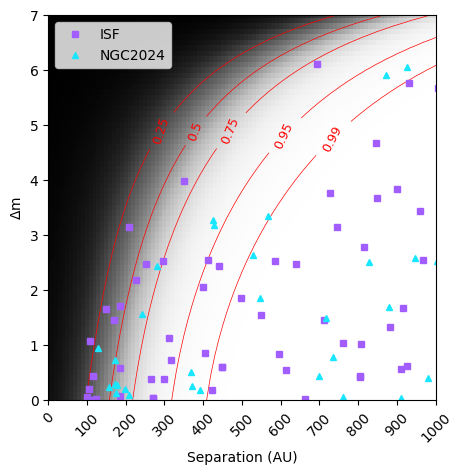

In [57]:
dms = np.arange(0, 7.01, 1/10)
seps = np.arange(0, 2001., 100/10)
dm_mtx, sep_mtx = np.indices((len(dms), len(seps)))
#sep_mtx = np.tile(np.arange(0, 2000.1, 0.1), )
dm_mtx, sep_mtx = (np.flip(dm_mtx,0))/10, 100*(sep_mtx+5)/10
frac_mtx = np.zeros(dm_mtx.shape)
n_dm = len(dms)
for i in range(len(mu)):
    frac_mtx[i, :] =  norm_logistic_reg(seps, mu[i], sig[i])
    
cmap = plt.cm.cool
category_colors = plt.colormaps['cool'](np.linspace(0.10, 0.85, 8))

fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(frac_mtx, origin='lower', cmap='Greys_r', aspect="auto")


c25 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.25], colors='r', alpha=0.99, linewidths=0.5)
c50 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.50], colors='r', alpha=0.99, linewidths=0.5)
c75 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.75], colors='r', alpha=0.99, linewidths=0.5)
c95 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.95], colors='r', alpha=0.99, linewidths=0.5)
c99 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.99], colors='r', alpha=0.99, linewidths=0.5)

xt = ax.get_xticks()
#ax.set_xticks(xt[1::], np.round(xt[1::]*100/10).astype(int))
ax.set_xticks(np.arange(0, 201, 10), np.arange(0, 2001, 100), rotation=45)
yt = ax.get_yticks()
ax.set_yticks(yt[1:-1], np.round((yt[1:-1])/10).astype(int))


manual_locations = [(20, 50)]
plt.clabel(c25, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(30, 50)]
plt.clabel(c50, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(40, 50)]
plt.clabel(c75, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(50, 50)]
plt.clabel(c95, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(60, 50)]
plt.clabel(c99, fontsize=9, inline=1, manual=manual_locations)

ax.set_xlabel('Separation (AU)')
ax.set_ylabel('$\Delta$m')


ra_cat, dec_cat, m_cat, i_yso = ra_f2, dec_f2, m_f2, i_yso
N_total = len(i_yso)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 2000
r1_cont = 2000
r2_cont = 5000

#Making a catalog object using all sources
c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
              distance=400.*u.pc, frame='fk5')

ra_yso  = ra_cat[i_yso]
dec_yso = dec_cat[i_yso]
m_yso   = m_cat[i_yso]

i_tested = np.array([])
N_cand   = np.array([])

d_comp = np.array([])
dm_comp = np.array([])
r_comp = np.array([])
dc_comp = np.array([])
mag_prim = np.array([])

for i in range(N_total):
    #Making a catalog object using YSO
    c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
    sep_     = c2.separation(c1).arcsec*400.
    i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
    n_obj    = len(i_obj_)

    if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.)&(m_yso[i]>12.):
        ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
        dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
        m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array

        i_prim, = np.where(m_sys==np.min(m_sys))
        i_comp, = np.where(m_sys!=np.min(m_sys))
        N_cand  = N_cand + len(i_comp)
        ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
        ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
        m_prim = m_sys[i_prim]
        c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')

        c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
        sep_comp = c_comp.separation(c_prim).arcsec*400.
        #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
        d_comp = np.append(d_comp, sep_comp)
        dm_comp = np.append(dm_comp, np.abs((m_sys[i_comp]-m_prim)))
        r_comp, dc_comp = np.append(r_comp, ra_comp), np.append(dc_comp, dec_comp)
        mag_prim = np.append(mag_prim, np.ones(ra_comp.shape)*m_prim[0])
ax.plot(d_comp/10, dm_comp*10, 's', c=category_colors[5], ms=4, label='ISF')
ax.plot(sep_flame/10, dm_flame*10, '^', c=category_colors[0], ms=4, label='NGC2024')

ax.set_yticks(np.arange(0, 71, 10), np.arange(0, 8, 1))
ax.set_ylim(0, 70)

ax.set_xlim(0, 100)
ax.legend()

In [70]:
def CF(ra_cat, dec_cat, m_cat, i_yso):
    N_total = len(i_yso) #Total number of YSOs
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    bw = 100
    bins = (np.zeros((len(i_yso), len(np.arange(1, 5000/bw+1, 1)))))
    bin_count = np.arange(1, 5000/bw+1, 1, dtype=int)

    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=400.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R     = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont  = 0
    d_mag   = np.array([])
    dist    = np.array([])
    cont_m  = np.array([])
    #fig, ax = plt.subplots()
    
    for i in range(N_total):
        #Making a catalog object using the ith YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))#&(m_cat>10.5))
        n_obj    = len(i_obj_)
        
        for i_bin in bin_count:
            i_obj_bin,  = np.where((sep_>=i_bin*bw)&(sep_<=(i_bin*bw+bw)))
            bins[i,i_bin-1] = np.sum(i_obj_bin)
                                 
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            if len(i_tested)==0:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=False)
            else:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=True)
            
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            
            m_prim = m_sys[i_prim]
            m_comp = m_sys[i_comp]
            
            if np.abs(m_comp - m_prim).any() <= 7.0:
                i_comp = i_comp[np.abs(m_comp - m_prim)<=7.0]
                m_comp = m_sys[i_comp]

                ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
                ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]

                c_comp   = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
                c_prim   = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
                sep_comp = c_comp.separation(c_prim).arcsec*400.

                #making a new cat obj with the dimmest objects in the system
                #n_obj is recalculated using the "new" primary.
                sep      = c2.separation(c_prim).arcsec*400.
                i_obj_,  = np.where((sep>=r1_comp)&(sep<=r2_comp))#&(m_cat>10.5))
                n_obj    = len(i_obj_)
                N_cand   = N_cand + n_obj
                i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
                
        else:
            m_prim   = m_yso[i]
            i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont      = 0
        #if len(i_cont)>0: #N_contaminants is calculated around all YSOs in the region.
        for j in range(len(i_cont)):
            delta_m = m_cat[i_cont[j]]-m_prim
            cont_m = np.append(cont_m, m_cat[i_cont[j]])
            dm_int  = int(np.abs(10*np.round(delta_m, 1)))
            if dm_int>70: #80: delta_mag=8
                mu_, sig_ = 0, 0
                R_ = 0
            else:
                mu_  = mu[dm_int]
                sig_ = sig[dm_int]
                I  = quad(r_times_logistic_reg, r1_comp, r2_comp, args=(mu_, sig_))
                R_ = 2*np.pi * I[0] / (np.pi*(r2_cont**2 - r1_cont**2))
                R  = np.append(R, R_)
                d_mag=np.append(d_mag,dm_int)
                R_unc   = np.append(R_unc, I[1])
                dist = np.append(dist, sep_[i_cont[j]])
            n_cont  = n_cont + R_


        N_cont_corr = np.append(N_cont_corr, n_cont)
        N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                      len(i_cont)*
                                      (r2_comp**2-r1_comp**2)/(r2_cont**2-r1_cont**2))
        #N_cont = np.append(N_cont, n_cont)


        
            
        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
        
        
        
    N_comp   = N_cand - np.sum(N_cont_corr)
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    #for i in range(len(dist)):
    #    ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: '+str(N_cand)+'/'+str(N_total))
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print('N_comp: ', N_comp)
    print('CF:', N_comp/N_total)
    return d_mag, N_cont_corr, dist, cont_m, bins, bin_count

In [71]:
dmag, N_cont_arr, dist, cmag, sig_bins, bin_count,  = CF(ra_f2, dec_f2, m_f2, i_yso)

N_cand: 92/671
N_cont within 200-5000 (before correction):  40.30714285714286
N_cont within 200-5000:  32.34704739197907
N_contaminants:  855.0
N_comp:  59.65295260802093
CF 0.08890156871538142


In [72]:
bw=100
bin_radii = bin_count*bw
bin_areas = np.pi*((bin_radii)**2-(bin_radii-bw)**2)
bin_mean = np.mean(sig_bins, axis=0)/bin_areas

### P($<\Delta$r) = $\frac{r^2 - r^2_{1}}{r^2_{2} - r^2_{1}}$

$r_1$ = 100, 
$r_2$ = 1000

$r = \sqrt{N(r_2^2 - r_1^2) + r_1^2}$

In [522]:
def P_r(r):
    r1, r2 = 100, 1000
    return (r**2 - r1**2)/(r2**2 - r1**2)

def inv_P_r(n):
    r1, r2 = 100, 1000
    return np.sqrt(n*(r2**2 - r1**2) + r1**2)

Text(0, 0.5, 'f ($\\Delta$r)')

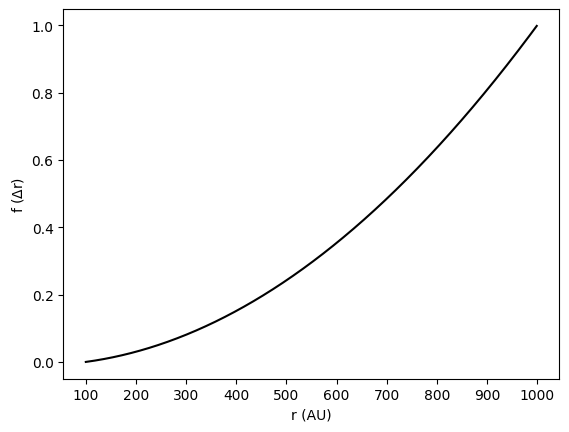

In [181]:
fig, ax = plt.subplots()
ax.plot(np.arange(100, 1000, 1), P_r(100, 1000, 1), 'k-')
ax.set_xticks(np.arange(100, 1100, 100))
ax.set_xlabel('r (AU)')
ax.set_ylabel('f ($\Delta$r)')

### P($<\Delta$m)

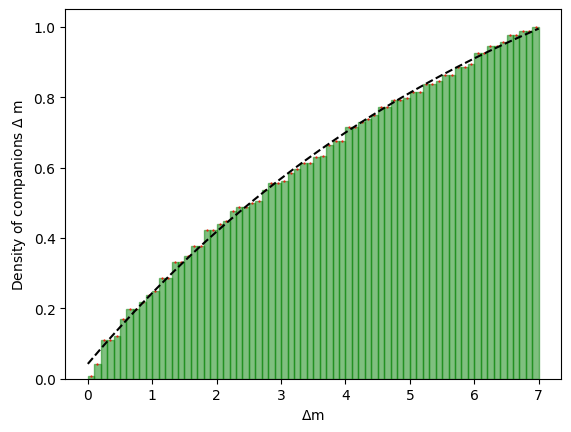

In [648]:
plt.subplot()
bw=100
n, bins, patches = plt.hist(dmag/10, bins=np.arange(0, 7.051, 0.1),
                             cumulative=True, density=True,
                           color='green', alpha=0.5, edgecolor='g')
#plt.plot(bins[0:-1]+0.05, n, '.r')
plt.xlabel('$\Delta$m')
plt.ylabel('Density of companions $\Delta$ m')

#interpolated = pm.Interpolated.dist(np.arange(0, 8, 1), )
def parabola(x, a, b, c):
    return a - b*np.exp(-c*(x))
plt.plot(bins[0:-1]+0.05, n, '.r', ms=1)
popt, pcov = curve_fit(parabola, bins[0:-1]+0.05, n, p0=[1, 100, 1])
#mu = popt

x = np.arange(0, 7.00001, 0.01)
plt.plot(x, parabola(x, *popt), 'k--', ms=1)
#plt.axhline(0.8)

def inv_delm(n, a, b, c):
    return -1/c*np.log((a - n)/b)

In [881]:
popt

array([1.53778978, 1.49562009, 0.14470388])

### P($<\Delta$m) = A - B $\cdot e^{-C \cdot x}$ (CDF),

where A = 1.19178628e+03, B = 1.15910484e+03, and C = 1.44704046e-01

### dP($<\Delta$m) = B$\cdot$C$\cdot e^{-C\cdot x} \cdot dx$ (PDF)

### $x = -\frac{ln[\frac{dP/dx}{BC}]}{C}$

## $P(\Sigma_{los} | N_{cont})= \frac{(\Sigma_{los}\Omega_{cont})^{N_{cont}}}{N_{cont}!}e^{-\Sigma_{los}\Omega_{cont}}$

### Poisson distribution = $\frac{\mu^{x}}{x!}\cdot e^{-\mu}$

$N_{cont} \sim Poisson()$

$P(\Sigma_{los} | N_{cont}) \sim Gamma()$

----

## Step 1: The model for N_contaminants distribution
(tune: number of samples to draw during MCMC parameter tuning before the actual sample draw)

Line 7 - sigma_los parameter

Line 8 - observed N_contaminants distributions ffrom each sigma_los

Line 9 - Trace object containing samples collected ()

Line 10 - posterior estimates

In [908]:
SEED = np.random.randint(100000)

SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "draws":1000,
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

with pm.Model() as P_Ncont:
    sigma          = pm.Gamma('sig', alpha=855+1, beta=O_cont)
    y_obs          = pm.Poisson('Ncont', mu=sigma*O_comp)
    Ncont_trace    = pm.sample(**SAMPLE_KWARGS, progressbar=False)
    Ncont_forecast = pm.sample_posterior_predictive(Ncont_trace, var_names=['sig', 'Ncont'], progressbar=False)

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [sig]
>Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Sampling: [Ncont, sig]


## Step 2: Randomly picking one N

Ncont_forecast.**posterior_predictive**['Ncont'].**data**,   gives the **data** of the **posterior_predictive**

This is an array of (4, 100) shape. 4 chains of 1000 draws (below).

The *trace plots* show the distributions. Lower left is the 4 Sigma distributions. And the Upper left is that of N_contaminants (N_cont)

array([[<Axes: title={'center': 'Ncont'}>,
        <Axes: title={'center': 'Ncont'}>],
       [<Axes: title={'center': 'sig'}>, <Axes: title={'center': 'sig'}>]],
      dtype=object)

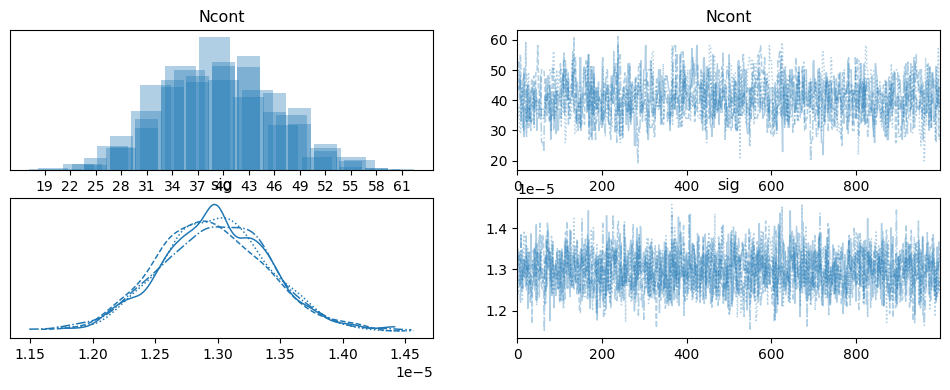

In [909]:
az.plot_trace(Ncont_trace)

### So, we flatten the 2-D array
Using **.flatten()** Which makes it a 1_D array.

Then (pseudo-)randomly choose one N from the distribution.

In [ ]:
N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()

chosen_N  = random.choice(N_)

## Step 3:  N_cont_det

Now we calculate the sum of all **chosen_N** of the fractions

In [914]:
j = 0
while j < chosen_N:
    
    ran_decim   = np.random.randint(100000)/100000
    j_dm_       = inv_delm(ran_decim, a, b, c)
    if (j_dm_ > 7.):
        continue
    elif (j_dm_ < 0.):
        f_j = np.append(f_j, 0.)
        j += 1
    else:
        j_r_      = inv_P_r(ran_decim)
        j_dm, j_r = int(np.round(j_dm_, 1)*10), int(np.round(j_r_/10))
        f_j       = np.append(f_j, frac_mtx[j_dm,j_r])
        j += 1
N_cont_det = np.append(N_cont_det, np.sum(f_j))
#t2 = time.time()        

In [915]:
N_cont_det

array([360.71093146])

--------

In [913]:
N_cont_det = np.array([])

In [916]:
f_j

array([0.99212146, 0.99962361, 0.99676573, 0.99955301, 0.99132666,
       0.99921963, 0.99132666, 0.94727905, 0.98720411, 0.88443831,
       0.98543776, 0.99953194, 0.88219485, 0.95587856, 0.99953394,
       0.99941859, 0.97917607, 0.99902058, 0.96489914, 0.99962791,
       0.99957321, 0.99924651, 0.99902058, 0.96754917, 0.94727905,
       0.99676233, 0.99955982, 0.99848332, 0.99757111, 0.99212146,
       0.99956429, 0.99636235, 0.99767471, 0.99962702, 0.99954376,
       0.99057169, 0.99920574, 0.99882636, 0.9993834 , 0.        ,
       0.99940101, 0.99513042, 0.99638017, 0.99953394, 0.96489914,
       0.94727905, 0.99949664, 0.99860515, 0.99955301, 0.99910367,
       0.99883361, 0.99955982, 0.99789126, 0.99920574, 0.99941859,
       0.99902058, 0.99941859, 0.99947469, 0.99767471, 0.99940101,
       0.98987558, 0.92573659, 0.99953194, 0.99961053, 0.99956429,
       0.99916259, 0.99132666, 0.99860515, 0.9953918 , 0.78897045,
       0.        , 0.99873177, 0.99915844, 0.99221022, 0.99961

In [893]:
chosen_Ns = np.array([])
chosen_sigs = np.array([])
arr_seeds = np.array([])
N_cont_det = np.array([])
a, b, c   = popt

In [809]:
len(chosen_Ns),len(chosen_sigs),len(arr_seeds),len(N_cont_det)

(873260, 1000, 1001, 873260)

In [772]:
for i in range(100):
    print('Loop '+str(i))
    SEED = np.random.randint(100000)
    SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "draws":1000,
                             "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}
    with pm.Model() as P_siglos:
        y_obs = pm.Gamma('sig', alpha=855+1, beta=O_cont)
        sig_trace = pm.sample(**SAMPLE_KWARGS, progressbar=False)
        sig_forecast = pm.sample_posterior_predictive(sig_trace, var_names=['sig'], progressbar=False)

    sig_       = sig_forecast.posterior_predictive['sig'].data.flatten()
    chosen_sig = random.choice(sig_)
    chosen_sigs = np.append(chosen_sigs, chosen_sig)

    SEED = np.random.randint(100000)
    arr_seeds = np.append(arr_seeds, SEED)

    SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "draws":1000,
                     "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

    with pm.Model() as P_Ncont:
        y_obs          = pm.Poisson('Ncont', mu=chosen_sig*O_comp)
        Ncont_trace    = pm.sample(**SAMPLE_KWARGS, progressbar=False)
        Ncont_forecast = pm.sample_posterior_predictive(Ncont_trace, var_names=['Ncont'], progressbar=False)
        
    N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
    chosen_N  = random.choice(N_)
    chosen_Ns = np.append(chosen_Ns, chosen_N)

    f_j = np.array([])
    j = 0
    while j < chosen_N:
        ran_dec   = np.random.randint(10000)/10000
        j_dm_     = inv_delm(ran_dec, a, b, c)
        if (j_dm_ > 7.)|(j_dm_ < 0):
            continue
        else:
            j_r_      = inv_P_r(ran_dec)
            j_dm, j_r = int(np.round(j_dm_, 1)*10), int(np.round(j_r_/10))
            f_j       = np.append(f_j, frac_mtx[j_dm,j_r])
            j += 1
    N_cont_det = np.append(N_cont_det, np.sum(f_j)/chosen_N)


Loop 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [Ncont]


Loop 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 2


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [Ncont]


Loop 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 4


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 5


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 6


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 7


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 8


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 9


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]


Loop 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 11


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 12


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]


Loop 13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 14


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 15


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 16


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 17


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 18


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 19


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [sig]
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [Ncont]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Loop 20


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]


KeyboardInterrupt: 

In [860]:
chosen_Ns_1000 = chosen_Ns
chosen_sigs_1000 = chosen_sigs
arr_seeds_1000 = arr_seeds
N_cont_det_1000 = N_cont_det

(1060,)

In [861]:
chosen_Ns.shape

(873260,)

In [777]:
len(chosen_Ns),len(chosen_sigs),len(arr_seeds),len(N_cont_det)

(792261, 920, 920, 792260)

In [805]:
chosen_sigs.shape, N_cont_det.shape[0]-792000, k

((919,), 260, 999)

#### the following loops broken at loop 919. Therefore ran a separate set of oterations for 81 samples`

In [883]:
t1 = time.time()
#looping 10,000 times
SEED = np.random.randint(100000)
SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "draws":250,
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}
with pm.Model() as P_siglos:
    y_obs = pm.Gamma('sig', alpha=855+1, beta=O_cont)
    sig_trace = pm.sample(**SAMPLE_KWARGS, progressbar=False)
    sig_forecast = pm.sample_posterior_predictive(sig_trace, var_names=['sig'], progressbar=False)

sig_       = sig_forecast.posterior_predictive['sig'].data.flatten()
#chosen_sig = random.choice(sig_)
chosen_sigs = sig_ #not choising randomly anymore. but using the same name

for i in range(len(sig_)):

    SEED = np.random.randint(100000)
    #arr_seeds = np.append(arr_seeds, SEED)

    SAMPLE_KWARGS = {"chains": 4, "tune": 100, "draws":1,
                     "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

    with pm.Model() as P_Ncont:
        y_obs          = pm.Poisson('Ncont', mu=sig_[i]*O_comp)
        Ncont_trace    = pm.sample(**SAMPLE_KWARGS, progressbar=False)
        Ncont_forecast = pm.sample_posterior_predictive(Ncont_trace, var_names=['Ncont'], progressbar=False)

    N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
    for k in range(1000):
        chosen_N  = random.choice(N_)
        chosen_Ns = np.append(chosen_Ns, chosen_N)

        f_j = np.array([])
        j = 0
        while j < chosen_N:
            ran_decim   = np.random.randint(100000)/100000
            j_dm_       = inv_delm(ran_decim, a, b, c)
            if (j_dm_ > 7.):
                continue
            elif (j_dm_ < 0.):
                f_j = np.append(f_j, 0.)
            else:
                j_r_      = inv_P_r(ran_decim)
                j_dm, j_r = int(np.round(j_dm_, 1)*10), int(np.round(j_r_/10))
                f_j       = np.append(f_j, frac_mtx[j_dm,j_r])
                j += 1
        N_cont_det = np.append(N_cont_det, np.sum(f_j))
t2 = time.time()        

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]
Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 50 seconds.
Sampling: [sig]
Only 1 samples in chain.
Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]
Sampling 4 chains for 100 tune and 1 draw iterations (400 + 4 draws total) took 38 seconds.
/Users/Prabhani/opt/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
The number of samples is too small to check convergence reliably.
Sampling: [Ncont]
/Users/Prabhani/opt/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only 1 samples in chain.
Multiprocess sampling (4 chains in 2 

KeyboardInterrupt: 

In [904]:
N_cont_det.shape

(137,)

/Users/Prabhani/opt/anaconda3/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:425: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left=data.draw.min(), right=data.draw.max())
/Users/Prabhani/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/Prabhani/opt/anaconda3/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:425: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left=data.draw.min(), right=data.draw.max())


array([[<Axes: title={'center': 'Ncont'}>,
        <Axes: title={'center': 'Ncont'}>],
       [<Axes: title={'center': 'sig'}>, <Axes: title={'center': 'sig'}>]],
      dtype=object)

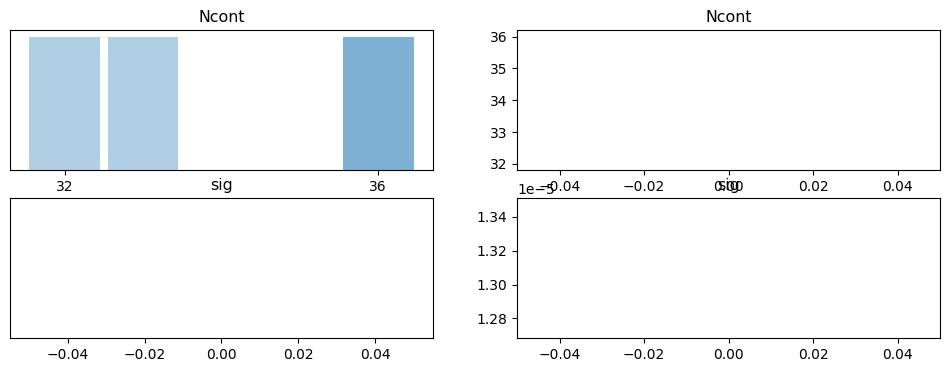

In [905]:
az.plot_trace(Ncont_trace)

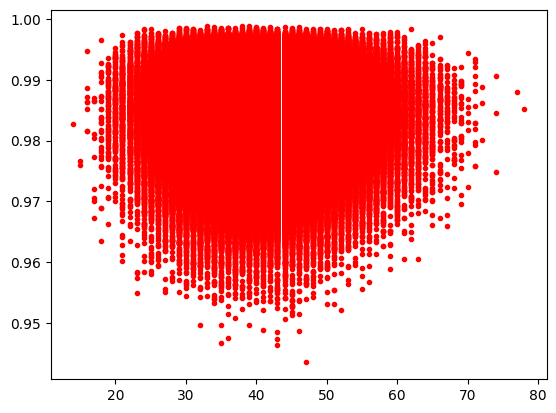

In [880]:
plt.subplots()
plt.plot(chosen_Ns[chosen_Ns==], N_cont_det, '.r')

Text(0.5, 0, '$N_{comp} = N_{cand} - N_{cont}^{det}$')

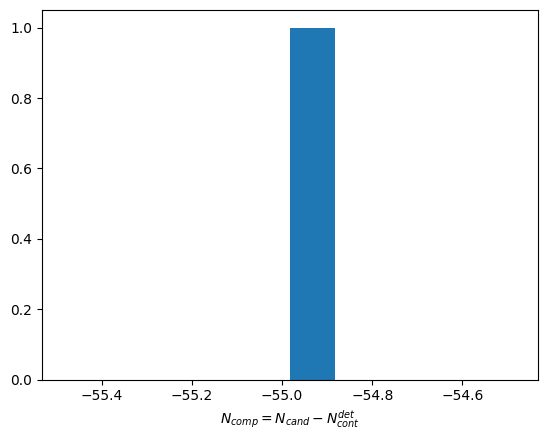

In [897]:
#with 100 sigmas and 5 N_los chosen
plt.subplots()
plt.hist(92 - N_cont_det)#, bins=np.arange(25, 75, 1), density=True)
plt.xlabel('$N_{comp} = N_{cand} - N_{cont}^{det}$')
#plt.xlabel('Fraction of Detection')

Text(0.5, 0, '$N_{comp} = N_{cand} - N_{cont}^{det}$')

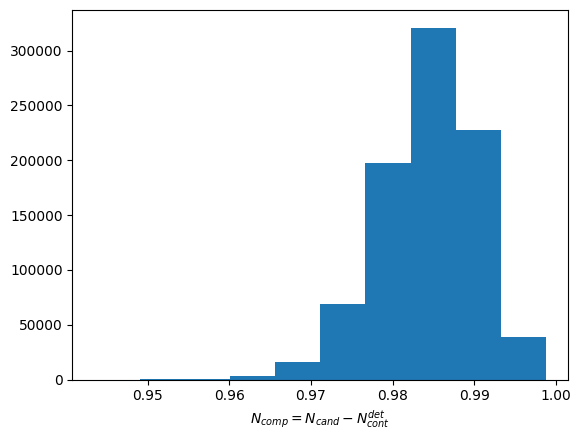

In [857]:
#with 100 sigmas and 5 N_los chosen
plt.subplots()
plt.hist(N_cont_det)#, bins=np.arange(25, 75, 1), density=True)
plt.xlabel('$N_{comp} = N_{cand} - N_{cont}^{det}$')
#plt.xlabel('Fraction of Detection')

Text(0.5, 0, '$N_{comp} = N_{cand} - N_{cont}^{det}$')

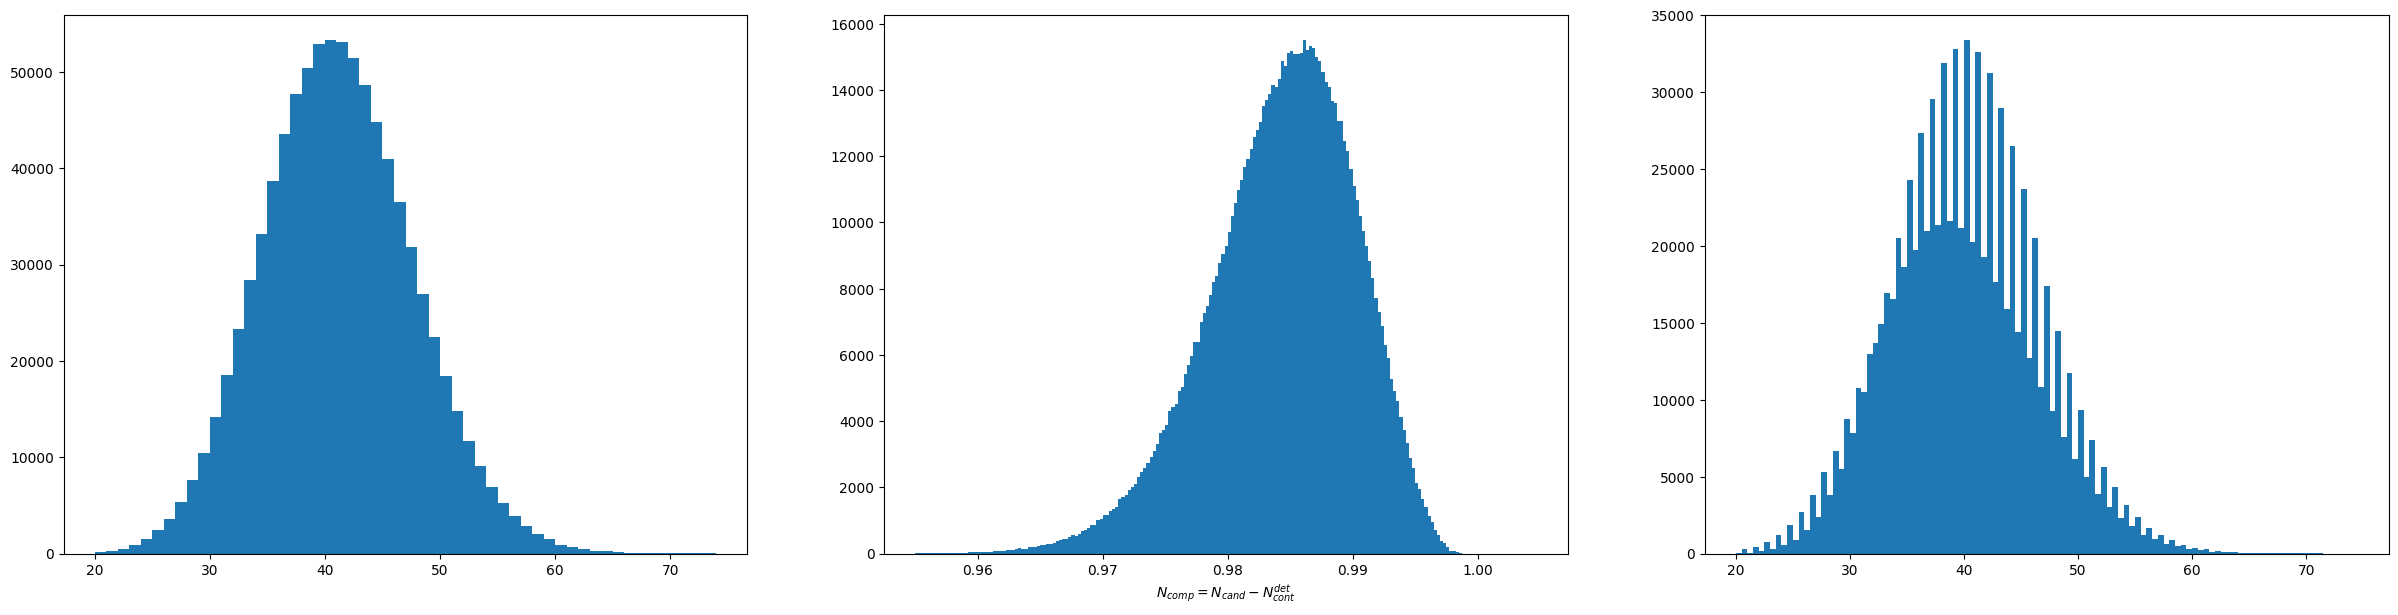

In [876]:
#with 100 sigmas and 5 N_los chosen
fig, ax = plt.subplots(1, 3, figsize=(30, 7))
ax[0].hist(chosen_Ns, bins=np.arange(20, 75, 1))#, bins=np.arange(25, 75, 1), density=True)
ax[1].hist(N_cont_det, bins=np.arange(0.955, 1.005, 0.00025))#, bins=np.arange(25, 75, 1), density=True)
ax[2].hist(chosen_Ns*N_cont_det, bins=np.arange(20, 75, 0.5))#, bins=np.arange(25, 75, 1), density=True)
ax[1].set_xlabel('$N_{comp} = N_{cand} - N_{cont}^{det}$')
#plt.xlabel('Fraction of Detection')

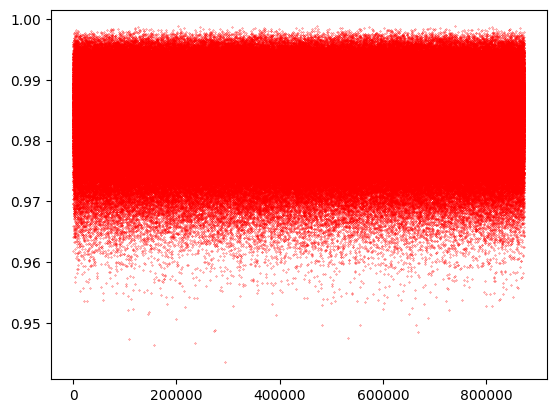

In [875]:
plt.subplots()
plt.plot(N_cont_det, '.r', ms=0.5)

Text(0.5, 0, 'Fraction of Detection')

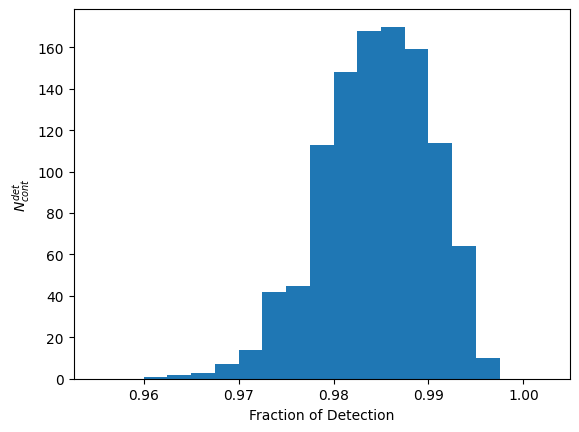

In [718]:
#with 100 sigmas and 5 N_los chosen
plt.subplots()
plt.hist(N_cont_det, bins=np.arange(0.955, 1.005, 0.0025))
plt.ylabel('$N_{cont}^{det}$')
plt.xlabel('Fraction of Detection')

(array([  0.,   0.,   0.,   0.,  12.,  69., 108., 159., 169., 165., 146.,
        111.,  51.,  41.,  16.,   5.,   5.,   2.,   1.]),
 array([51. , 51.1, 51.2, 51.3, 51.4, 51.5, 51.6, 51.7, 51.8, 51.9, 52. ,
        52.1, 52.2, 52.3, 52.4, 52.5, 52.6, 52.7, 52.8, 52.9]),
 <BarContainer object of 19 artists>)

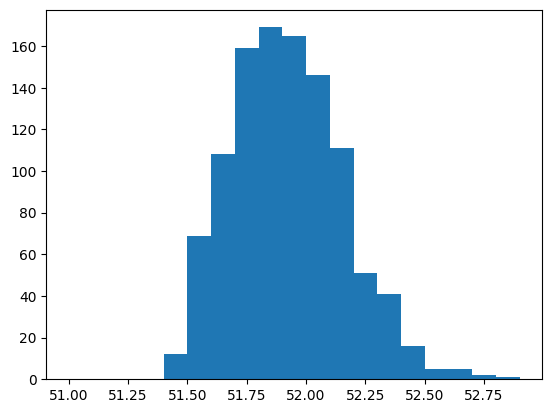

In [703]:
#with 100 sigmas and 5 N_los chosen
plt.subplots()
plt.hist((92-N_cont_det*855*O_comp/O_cont), bins=np.arange(51., 53., 0.1))
plt.ylabel('$N_{cont}^{det}$')
plt.xlabel('Fraction of Detection')

(array([ 4.,  9., 15., 30., 14., 19.,  7.,  4.,  6.]),
 array([51.5, 51.6, 51.7, 51.8, 51.9, 52. , 52.1, 52.2, 52.3, 52.4]),
 <BarContainer object of 9 artists>)

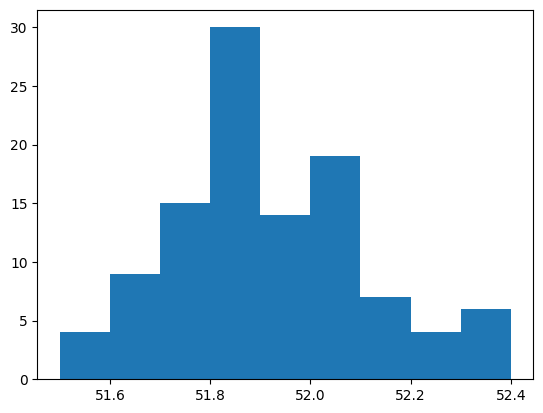

In [691]:
#with 100 sigmas and 1 N_los chosen
plt.subplots()
plt.hist((92-N_cont_det*855*O_comp/O_cont), bins=np.arange(51.5, 52.5, 0.1))

In [670]:
np.max((92-N_cont_det*855*O_comp/O_cont)/671)

0.0780949585051563

(array([1., 1., 1., 2.]),
 array([7.80051226, 7.8632549 , 7.92599754, 7.98874018, 8.05148282]),
 <BarContainer object of 4 artists>)

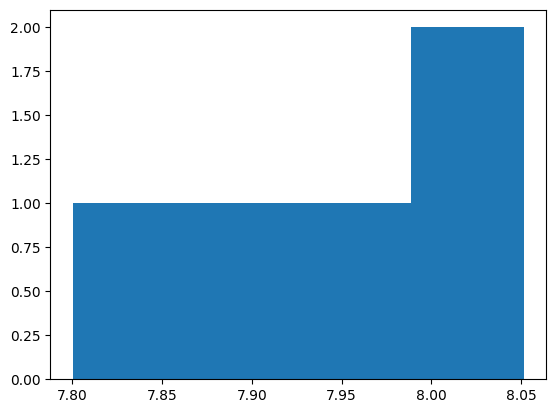

In [623]:
plt.subplots()
plt.hist((92-855*N_cont_det/O_cont*O_comp)/671*100, bins=4)

In [611]:
855*N_cont_det/O_cont*O_comp

array([38.68478821, 39.65856276, 38.02652   , 39.04885995, 37.9745503 ])

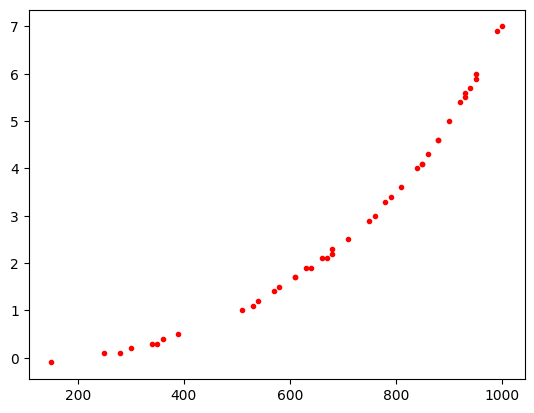

In [586]:
for j in range(chosen_N):
    ran_dec   = np.random.randint(10000)/10000
    j_dm_     = inv_delm(ran_dec, a, b, c)
    j_r_      = inv_P_r(ran_dec)
    j_dm, j_r = int(np.round(j_dm_, 1)*10), int(np.round(j_r_/10))
    plt.plot(j_r*10, j_dm/10, '.r')
    #print(j_dm_, j_r_, j_dm, j_r, frac_mtx[j_dm,j_r])

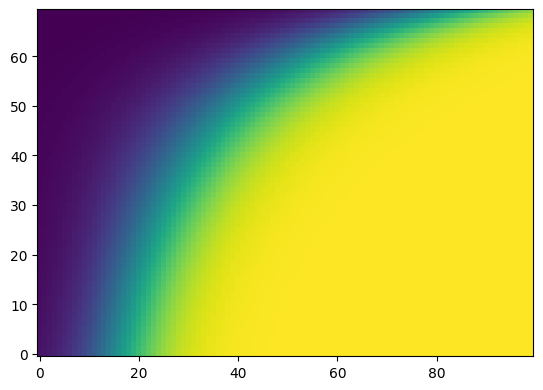

In [574]:
plt.subplots()
plt.imshow(frac_mtx[0:70, 0:100], origin='lower')

(array([ 0.,  0.,  0.,  0., 42.,  0.,  0.,  0.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4]),
 <BarContainer object of 9 artists>)

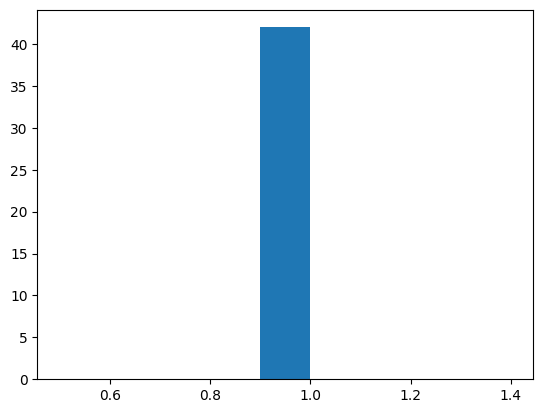

In [562]:
plt.subplots()
plt.hist(f_j, bins=np.arange(0.5, 1.5, 0.1))

In [545]:
np.max(frac_mtx)

0.9999999999999978

In [504]:
dm_forecast.posterior_predictive['dm'].data.flatten()

array([ 2.55805881, 32.23166548,  4.49122718, 11.32145739,  8.98594271,
        6.92354865, 15.51350927,  7.89181684,  2.56434714,  5.71407731,
       10.30361845,  9.73286367, 10.73785834,  0.69648944,  5.02068749,
        6.57952325,  5.31222603,  9.18400379,  0.42767609,  9.05893295,
       21.01800719, 10.86884022,  9.360399  ,  2.79932371, 20.99226594,
       19.7278347 ,  7.1289925 ,  8.34389917,  1.00408214,  0.30899392,
        2.93491686, 38.06825799, 15.26829202,  8.76119663, 34.46775191,
        0.93528103,  5.06903   , 10.36187912,  6.34842774,  3.26548334,
        8.10491102,  2.07982325,  5.5166104 ,  2.50072025, 15.27310959,
        1.33572717, 21.46354462])

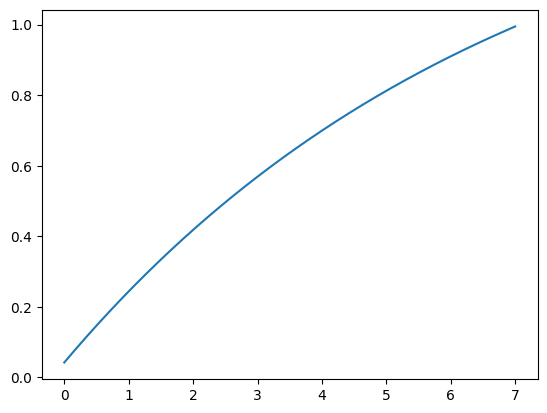

In [496]:
plt.subplots()
plt.plot(x, parabola(x, a, b, c))

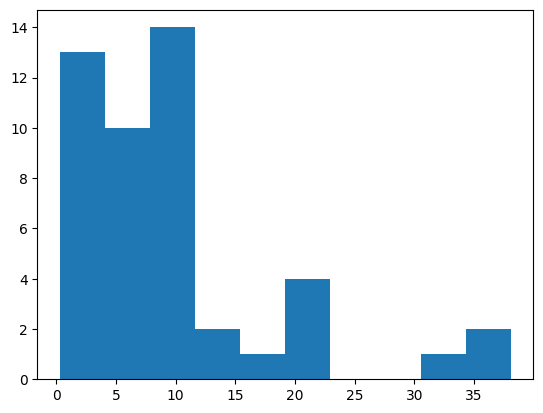

In [497]:
plt.subplots()
n, b, f = plt.hist(dm_forecast.posterior_predictive['dm'].data.flatten())

-----

Test scripts are below

In [128]:
def P_sig(sig, O_cont, N_cont):
    return pm.(sig*O_cont)**N_cont * np.exp(-sig*O_cont) / scipy.special.factorial(N_cont)

In [86]:
N_cand = 92
r1, r2 = 100, 1000
r3, r4 = 2000, 5000
O_cont = np.pi*(r4**2 - r3**2)
N_cont_ = N_cont_arr
sig_los = N_cont_arr/O_cont * np.pi * (r2**2 - r1**2)

*Note: missng constant = (N_cont+1)/O_cont*

In [182]:
with pm.Model() as P_siglos:
    y_obs = pm.Gamma('sig', alpha=855+1, beta=O_cont)
    sig_trace = pm.sample(draws=1000, chains=4)
    sig_forecast = pm.sample_posterior_predictive(sig_trace, var_names=['sig'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [sig]


In [188]:
sig_trace

Inference data with groups:
	> posterior
	> sample_stats

## 1000 Draws

### $\Delta m = -\frac{ln[(A - N)/B]}{c}$
$r = N(r_2^2 - r_1^2) + r_1^2$

In [376]:
def solv_delm(n_):
    a, b, c = 1.53778978, 1.49562009, 0.14470388
    return -1 * np.log((a-n_)/b) / c

def solv_r(n_):
    r1, r2 = 100, 1000
    return np.sqrt(n_ * (r2**2 - r1**2) + r1**2)

Text(0, 0.5, 'P($\\Sigma$)')

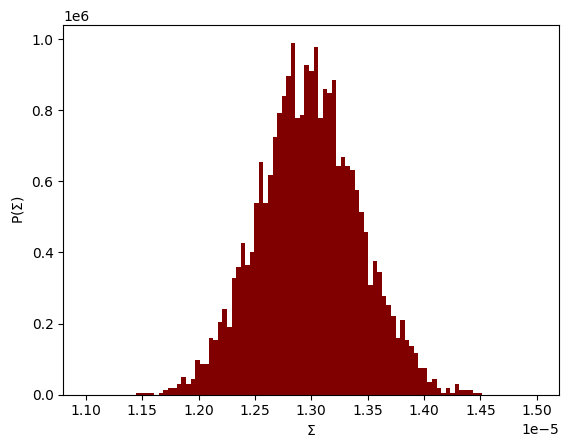

In [206]:
#with 1000 draws hist
fig, ax = plt.subplots()
ax.hist(sig_forecast.posterior_predictive['sig'].data.flatten()
        , density=True, bins=np.linspace(1.10e-5, 1.5e-5, 100), color='maroon')
ax.set_xlabel('$\Sigma$')
ax.set_ylabel('P($\Sigma$)')

Text(0, 0.5, 'P($\\Sigma$)')

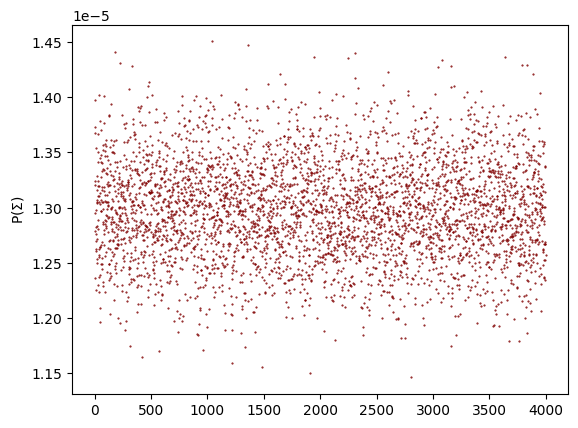

In [207]:
plt.subplots()
plt.plot(sig_forecast.posterior_predictive['sig'].data.flatten(), '.', ms=1, 
         color='maroon')
plt.ylabel('P($\Sigma$)')

In [212]:

O_comp = np.pi*(r2**2-r1**1)
r1, r2

(100, 1000)

In [240]:
for i in range(10):
    #random.seed()
    print(np.random.randint(1000000))

246216
501488
217474
386269
208693
994407
465078
909263
468670
531430


In [213]:
sig_       = sig_forecast.posterior_predictive['sig'].data.flatten()
chosen_sig = random.choice(sig_)


SEED = np.random.randint(100000)

SAMPLE_KWARGS = {"chains": 4, "tune": 1000,
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

with pm.Model() as P_Ncont:
    y_obs = pm.Poisson('Ncont', mu=chosen_sig*O_comp)
    Ncont_trace = pm.sample(draws=1000, chains=4, seed=SAMPLE_KWARGS)
    Ncont_forecast = pm.sample_posterior_predictive(Ncont_trace, var_names=['Ncont'])
    
chosen_N = random.choice(N_)

n_bin, bins, a = plt.hist(N_, cumulative=True, density=True, 
                      bins=np.arange(24.5, 65.5, 1))


Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [Ncont]


In [482]:
help(pm.Exponential)

Help on class Exponential in module pymc.distributions.continuous:

class Exponential(PositiveContinuous)
 |  Exponential(name: str, *args, rng=None, dims: Union[str, Sequence[Optional[str]], NoneType] = None, initval=None, observed=None, total_size=None, transform=UNSET, **kwargs) -> pytensor.tensor.var.TensorVariable
 |  
 |  Exponential log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \lambda) = \lambda \exp\left\{ -\lambda x \right\}
 |  
 |  .. plot::
 |      :context: close-figs
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      import arviz as az
 |      plt.style.use('arviz-darkgrid')
 |      x = np.linspace(0, 3, 100)
 |      for lam in [0.5, 1., 2.]:
 |          pdf = st.expon.pdf(x, scale=1.0/lam)
 |          plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
 |      plt.xlabel('x', fontsize=12)
 |      plt.ylabel('f(x)', fontsize=12)
 |      plt.legend(loc=1)
 | 

In [484]:
#SEED = np.random.randint(100000)

#SAMPLE_KWARGS = {"chains": 4, "tune": 100,
#                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}
a, b, c = pop
with pm.Model() as P_dm:
    y_obs = popt[0] - popt[1]/popt[2]*pm.Exponential('dm', lam=popt[2])
    dm_trace = pm.sample(draws=47, chains=1, random_seed=np.random.randint(100000))
    dm_forecast = pm.sample_posterior_predictive(dm_trace, var_names=['dm'])
    
#chosen_N = random.choice(N_)


NameError: name 'pop' is not defined

(array([24., 12.,  5.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.11681977e-02, 4.56067231e+00, 9.10017642e+00, 1.36396805e+01,
        1.81791846e+01, 2.27186887e+01, 2.72581929e+01, 3.17976970e+01,
        3.63372011e+01, 4.08767052e+01, 4.54162093e+01]),
 <BarContainer object of 10 artists>)

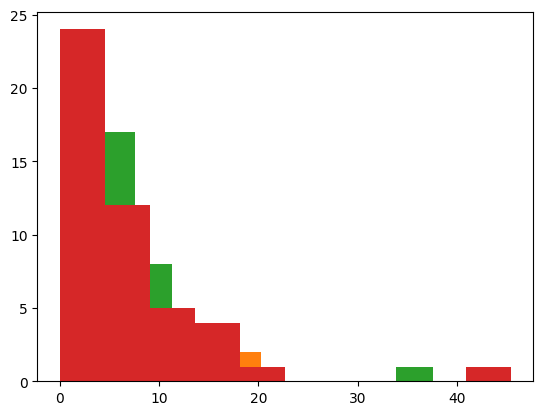

In [479]:
dm_arr = dm_forecast.posterior_predictive['dm'].data
plt.subplots()
plt.hist(dm_arr[0])
plt.hist(dm_arr[1])
plt.hist(dm_arr[2])
plt.hist(dm_arr[3])

In [ ]:
plt.xlabel('N_cont drawn from the distribution')
plt.ylabel('density of N_cont')

Text(0.5, 0, 'N_cont drawn from the distribution')

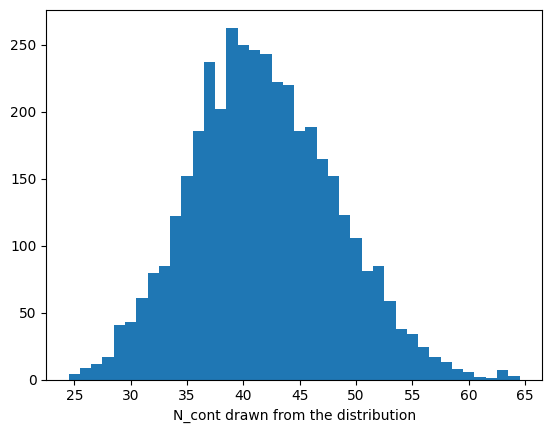

In [411]:
N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
plt.subplots()
n_bin, bins, a = plt.hist(N_,
                      bins=np.arange(24.5, 65.5, 1))
#plt.arrow(47, 0.8, -47, 0, width=0.01, color='k', length_includes_head = True,
#         head_width=0.05, head_length=2)
#plt.vlines(47, 0, 0.8, color='k', ls='--')
plt.xlabel('N_cont drawn from the distribution')
#plt.ylabel('density of N_cont')

Text(0, 0.5, 'density of N_cont')

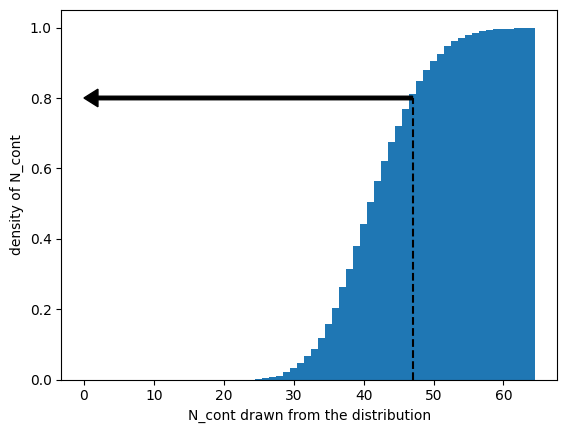

In [373]:
N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
plt.subplots()
n_bin, bins, a = plt.hist(N_, cumulative=True, density=True, 
                      bins=np.arange(24.5, 65.5, 1))
plt.arrow(47, 0.8, -47, 0, width=0.01, color='k', length_includes_head = True,
         head_width=0.05, head_length=2)
plt.vlines(47, 0, 0.8, color='k', ls='--')
plt.xlabel('N_cont drawn from the distribution')
plt.ylabel('density of N_cont')

In [402]:
solved_delm = solv_delm(n_)
solved_r    = solv_r(n_)
i_dm, i_r = int(np.round(solved_delm, 1)*10), int(np.round(solved_r/10))
frac_mtx[i_dm,i_r]

In [320]:
a, b, c = 1.53778978, 1.49562009, 0.14470388
n_ = n[np.where(bins==chosen_N-0.5)][0]
-1*np.log((a-n_)/b)/c

4.97730794152777

In [408]:
frac_mtx[i_dm,i_r]

0.9999997962190745

In [393]:
np.round(solved_delm, 1)

5.0

In [404]:
i_dm, i_r

(50, 90)